In [1]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.combine import SMOTETomek 

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv(r"C:\Users\Jaiprakash\OneDrive\Desktop\TestProject\SpamHamClassifier\SpamHam.txt", sep="\t", names=["Label", "messages"])

## Pre-processing the data
### Some common Problems:
- Remove Punctuation
- Replace short words
- Making text lower case
- Remove stopwords
- Lemmatization

In [4]:
# Replacing punctuations with space
df["message"] = df["messages"].copy()
df['message'] = df['message'].str.replace("[^a-zA-Z0-9]", " ")
df["message"]

0       Go until jurong point  crazy   Available only ...
1                           Ok lar    Joking wif u oni   
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor    U c already then say   
4       Nah I don t think he goes to usf  he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will   b going to esplanade fr home 
5569    Pity    was in mood for that  So   any other s...
5570    The guy did some bitching but I acted like i d...
5571                           Rofl  Its true to its name
Name: message, Length: 5572, dtype: object

In [5]:
#Remove short words and convert words to lower case
df["message"]=df["message"].apply(lambda row: " ".join([word.lower() for word in row.split() if len(word)> 2]))

In [6]:
#Remove stop words
stop_words = stopwords.words("english")
def remove_stopwords(sentence):
    sentence_list = word_tokenize(sentence)
    sentence_new = [word for word in sentence_list if word not in stop_words]
    return sentence_new
df["message"] = df["message"].apply(lambda row: " ".join(remove_stopwords(row)))

In [7]:
# Begin Lemmatization 
# function to convert nltk tag to wordnet tag
lemmatizer = WordNetLemmatizer()

# Finds the part of speech tag & Convert the detailed POS tag into a shallow information
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# lemmatize sentence using pos tag
def lemmatize_sentence(sentence):
    # word tokenize -> pos tag (detailed) -> wordnet tag (shallow pos) -> lemmatizer -> 
    # root word tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

df["message"] = df["message"].apply(lambda row: lemmatize_sentence(row))

In [8]:
# Importing module

# Creating matrix of top 2500 tokens
tfidf = TfidfVectorizer(max_features=2500)

X = tfidf.fit_transform(df.message).toarray()
y = df.Label.map({'spam' : 1, 'ham' : 0})
featureNames = tfidf.get_feature_names()

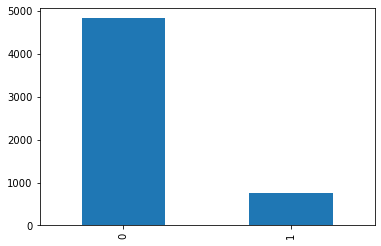

In [9]:
y.value_counts().plot(kind="bar")
plt.show()

In [10]:
smt = SMOTETomek(random_state=12)
X_smt, y_smt = smt.fit_resample(X, y)

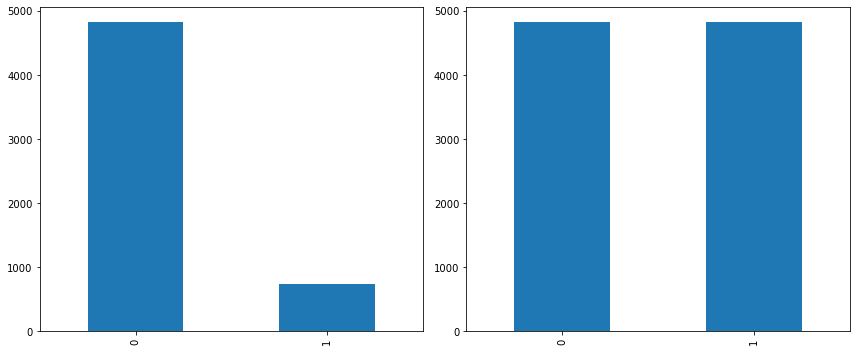

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(121)
y.value_counts().plot(kind="bar")
plt.subplot(122)
y_smt.value_counts().plot(kind="bar")
plt.tight_layout()
plt.show()

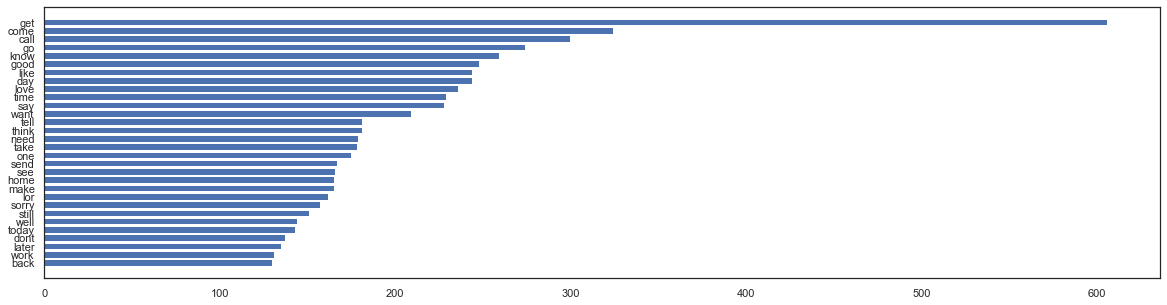

In [12]:
##
## Plotting most frequent words from positive reviews using bar chart
##
sns.set(style = 'white')
from nltk import FreqDist #function to find the frequent words in the data

# Subset ham message
all_words_df = df.loc[df['Label'] == 'ham',:]

#Extracts words into list and count frequency
all_words = ' '.join([text for text in all_words_df['message']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 30) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

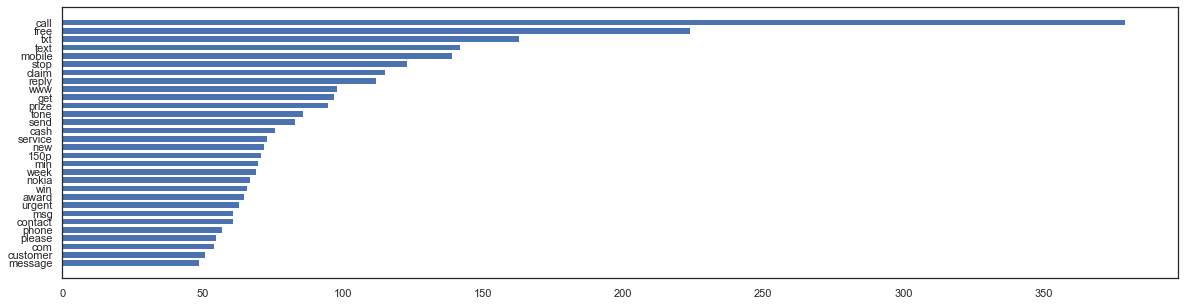

In [13]:
##
## Plotting most frequent words from positive reviews using bar chart
##

# Subset spam message
all_words_df = df.loc[df['Label'] == 'spam',:]

#Extracts words into list and count frequency
all_words = ' '.join([text for text in all_words_df['message']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 30) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

In [14]:
# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size = 0.20)

## Model Selection
Checking the performance of different models(Decision Tree, NaiveBayees) to the datasets

In [15]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)

y_pred = dt.predict(x_test)
roc_auc_score(y_test, dt.predict_proba(x_test)[:, 1])

0.9788858186601838

In [16]:
nb = MultinomialNB().fit(x_train, y_train)

y_pred=nb.predict(x_test)
roc_auc_score(y_test, nb.predict_proba(x_test)[:, 1])

0.9953033024125119

## Best Model
- From above metrics, could see Multinomial Naive Bayees algorithms in performing better for the datasets.
- Training our spamdetection model with MultinomialNB

In [17]:
spam_detection_model = MultinomialNB()
spam_detection_model.fit(x_train, y_train)

y_pred=spam_detection_model.predict(x_test)
roc_auc_score(y_test, nb.predict_proba(x_test)[:, 1])

0.9953033024125119

<AxesSubplot:>

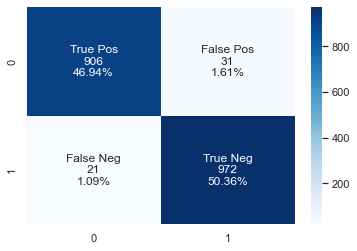

In [18]:
cm = confusion_matrix(y_test, y_pred)

group_names = ["True Pos","False Pos","False Neg","True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

In [19]:
roc_auc = roc_auc_score(y_test, spam_detection_model.predict_proba(x_test)[:, 1])
print("Performance of model: {}%".format(roc_auc))

Performance of model: 0.9953033024125119%
